#  Моделирование цены подержанных авто

Исходные данные 

Общие функции 
1. EDA - исследование исходных данных
   - 1.1 Считываем исходные данные
   - 1.2  Data Cleaning
        - 1.2.1. Проверка данных на дублирование
        - 1.2.2. Исследование пропущенных значений
        - 1.2.3. Исследование типов данных
2. Исследование признаков (визуализация, структура, оценка и отработка аномалий и выбросов)
   - 2.1. Исследование данных по пробегу -- "odometer"
   - 2.2. Исследование данных по году выпуска авто -- "year"
   - 2.3. Исследование данных по стоимости авто -- "price"
   - 2.4. Исследуем выбросы в количестве данных по годам - мало данных, убираем 2021,2022 гг
3. Feature Engineering
   - 3.1. Генерация дополнительных фичей -- odometer/price, desc_len, model_in_desc, age_category, model_len, model_word_count и пр
   - 3.2. Преобразование, нормализация
        - 3.2.1. Преобразование категориальных переменных 
        - 3.2.2. Стандартизация количественных переменных 
        - 3.2.3. Преобразование даты
   - 3.3. Преобразование датафрейма для этапа моделирования

4. Modelling
   -  4.1. Инициализация целевой переменной - price_category, разделение на сеты
   -  4.2. Обучение моделей разными методами
        - 4.2.1. Логистическая регрессия - точность на тестовом сете - 75,7%
        - 4.2.2. Случайный лес - точность на тестовом сете - 75,3%
        - 4.2.3. Многослойный персептрон - точность на тестовом сете - 78,4%
   - 4.3. Кросс-валидация на тренировочной выборке
   - 4.4. Выбор лучшей модели
   - 4.5. Кросс-валидация лучшей модели многослойного персептрона на тестовой выборке
5. RESULTS
6. Доп исследования
  -  6.1. Визуализации категориальной переменной вид топлива --- "fuel"  
  -  6.2. Визуализации категориальной переменной производителя --- "manufacturer"
  -  6.3. Визуализации категориальной переменной коробке передач автомобиля --- "transmission"
  -  6.4. Исследование зависимости стоимости автомобиля от года выпуска
  -  6.5. Исследование зависимости стоимости автомобиля от пробега
  -  6.6. Исследование зависимости пробега от года выпуска¶

Работаем с небольшой выборкой из коллекции подержанных автомобилей, выставленных на продажу в Соединённых Штатах.
На этих данных строим модель классификации, определяющую категорию цены подержанного автомобиля в зависимости от характеристик транспортного средства. 
<a id="1"></a> 
### Исходные данные 
Описание датасета, представленного в файле data/vehicles_dataset.csv:
- id: идентификатор записи;
- url: URL записи о продаже;
- region: регион;
- region_url: URL региона;
- price: стоимость;
- year: год выпуска;
- manufacturer: производитель;
- model: модель;
- condition: состояние;
- cylinders: количество цилиндров;
- fuel: тип топлива;
- odometer: количество пройденных миль;
- title_status: статус;
- transmission: коробка передач;
- VIN: идентификационный номер;
- drive: тип привода;
- size: размер;
- type: кузов;
- paint_color: цвет;
- image_url: URL изображения;
- description: указанное описание;
- county: страна;
- state: штат;
- lat: широта;
- long: долгота;
- posting_date: дата размещения объявления о продаже;
- price_category: категория цены.

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier

import missingno as msno

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 0. Общие функции

In [22]:
# Функция вывода общей информации  о выборке
def df_info_(df):
    print('Размер выборки -', df.shape)
    print('Состав выборки -', df.columns)
    return df.head(3)

In [23]:
# Функция выводы процента пропущенных значений по всем столбцам датафрейма по возрастанию
def missing_values(df):
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values()
    print('Процент пропущенных значений:')
    return missing_values

In [24]:
# Функция проверки полноты заполнения выборки
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))

In [51]:
# функция, вычисляющая границы, в которые должны попадать нормальные значения
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [56]:
# функция вывода графиков - гистрограмма и ящик с усами
def visual_hist_box(df, a):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 6), sharex=True)
    ax1.hist(df, bins=100, color='orange')
    ax1.set_title('Гистограмма')
    ax1.axvline(df.median(), color='red', linestyle='dashed', linewidth=1)
    ax1.set_xlabel('Распределение')
    ax1.set_ylabel('Частота')
    ax2.boxplot(df, sym='+', vert=False)
    ax2.set_title('Ящик с усами')
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'));
    fig.suptitle(a);

In [61]:
# функция вывода график - ящик с усами
def visual_box(df, a):
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.boxplot(df, vert=False)
    ax.set_ylabel('Стоимость')
    ax.set_title(a)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

## 1. EDA - исследование исходных данных

### 1.1. Считываем исходные данные

In [7]:
# Считываем исходную таблицу, определяем размерность, перечень колонок
df = pd.read_csv('data/vehicles_dataset.csv')
df_info_(df)

Размер выборки - (10050, 27)
Состав выборки - Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date', 'price_category'],
      dtype='object')


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,type,paint_color,image_url,description,county,state,lat,long,posting_date,price_category
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,good,NaN,...,pickup,silver,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,NaN,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,6 cylinders,...,SUV,black,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,NaN,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,good,NaN,...,sedan,NaN,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,NaN,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high


In [9]:
# Описательные статистики всего датасета 
df.describe()

,id,price,year,odometer,county,lat,long
count,1.005000e+04,1.005000e+04,10014.000000,1.000700e+04,0.0,9951.000000,9951.000000
mean,7.311544e+09,2.068429e+04,2010.917815,9.565719e+04,NaN,38.590164,-94.161564
std,4.475414e+06,1.243216e+05,9.697849,8.657948e+04,NaN,5.844756,18.123096
min,7.208550e+09,5.000000e+02,1915.000000,0.000000e+00,NaN,-67.144243,-158.069300
25%,7.308193e+09,7.900000e+03,2008.000000,3.899450e+04,NaN,34.830000,-110.447150
50%,7.312756e+09,1.574950e+04,2013.000000,8.837700e+04,NaN,39.285100,-87.999100
75%,7.315275e+09,2.799000e+04,2017.000000,1.370000e+05,NaN,42.427590,-80.830000
max,7.317090e+09,1.234568e+07,2022.000000,3.245000e+06,NaN,64.947500,173.885502


#### Выводы по исходному датасету
- 10050 строк, 27 столбцов
- всего 7 столбцов (включая  id) изначально числовые, остальные - категориальные
- видно большое количество пропущенных данных

In [10]:
# Исследование переменных датасета
for column in df:
    print('')
    print('Характеристика:', column)
    uniqvalue = df[column].nunique()
    print('Количество уникальных значений: ', uniqvalue)
    print('Список значений: ',  df[column].value_counts()) 


Характеристика: id
Количество уникальных значений:  10000
Список значений:  7316028281    2
7310693445    2
7310816094    2
7307639785    2
7312525382    2
             ..
7308265563    1
7309504220    1
7316238007    1
7311587823    1
7311960763    1
Name: id, Length: 10000, dtype: int64

Характеристика: url
Количество уникальных значений:  10000
Список значений:  https://roswell.craigslist.org/cto/d/artesia-1999-ford-f250-super-duty-super/7316028281.html         2
https://pueblo.craigslist.org/ctd/d/tempe-2017-ford-450-f450-450-drw-lariat/7310693445.html          2
https://monroe.craigslist.org/ctd/d/monroe-2019-infiniti-qx60-luxe/7310816094.html                   2
https://flint.craigslist.org/ctd/d/davison-2010-ford-150-xlt-supercrew/7307639785.html               2
https://charlotte.craigslist.org/cto/d/myrtle-beach-1947-mercury-hotrod-street/7312525382.html       2
                                                                                                    ..
https://mendo

Целевая переменная - категория цены  ----   'price_category'

In [12]:
# Исследование целевой переменной -   категория цены ---- 'price_category'
# Доли распределения количества данных по категориям цены
pd.crosstab(index=df['price_category'], columns='price_category', normalize = 'all')

col_0,price_category
price_category,
high,0.349652
low,0.322587
medium,0.327761


Как видно из таблицы целевая переменная имеет равномерное распределение

### 1.2.  Data Cleaning

### 1.2.1. Проверка данных на дублирование

In [13]:
df[df.duplicated()]

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,type,paint_color,image_url,description,county,state,lat,long,posting_date,price_category
1326,7312641615,https://pueblo.craigslist.org/cto/d/pueblo-196...,pueblo,https://pueblo.craigslist.org,6500,1969.0,chevrolet,c10,good,8 cylinders,...,NaN,red,https://images.craigslist.org/00f0f_kmR1TNWM4O...,"1969 C10 runs and drives clean body, needs inn...",NaN,co,38.032300,-104.716000,2021-04-25T20:15:43-0600,low
2159,7312437164,https://yakima.craigslist.org/ctd/d/parker-201...,yakima,https://yakima.craigslist.org,19995,2015.0,subaru,xv crosstrek,NaN,4 cylinders,...,SUV,white,https://images.craigslist.org/01414_cBd43F8IeC...,2015 Subaru XV Crosstrek 2.0i Limited AWD 4dr ...,NaN,wa,46.553190,-120.475680,2021-04-25T11:30:27-0700,medium
2398,7316719393,https://miami.craigslist.org/mdc/ctd/d/miami-2...,south florida,https://miami.craigslist.org,25590,2018.0,volkswagen,golf gti s hatchback,good,NaN,...,sedan,blue,https://images.craigslist.org/00y0y_7qosBCrp0z...,Carvana is the safer way to buy a car During t...,NaN,fl,25.770000,-80.200000,2021-05-04T11:01:11-0400,high
3067,7307971804,https://redding.craigslist.org/ctd/d/sacrament...,redding,https://redding.craigslist.org,8800,2008.0,honda,accord,excellent,NaN,...,sedan,silver,https://images.craigslist.org/00S0S_kT52djO80H...,2008 *** Honda Accord EX L w/Navi 4dr Sedan 5A...,NaN,ca,38.608824,-121.400837,2021-04-16T15:01:16-0700,low
3236,7307083381,https://westernmass.craigslist.org/ctd/d/sprin...,western massachusetts,https://westernmass.craigslist.org,21990,2017.0,gmc,acadia sle-1 sport utility,good,NaN,...,SUV,white,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,NaN,ma,42.110000,-72.530000,2021-04-15T06:10:54-0400,medium
3458,7316793777,https://desmoines.craigslist.org/ctd/d/martens...,des moines,https://desmoines.craigslist.org,6700,2015.0,ford,fusion se,good,4 cylinders,...,NaN,NaN,https://images.craigslist.org/00S0S_3wmNGwLyaE...,"2015 Ford Fusion SE, 2.5 4 cyl. automatic, air...",NaN,ia,41.373000,-93.735800,2021-05-04T11:59:42-0500,low
3547,7313511076,https://athensohio.craigslist.org/ctd/d/athens...,athens,https://athensohio.craigslist.org,23590,2012.0,ford,f150 supercrew cab xlt,good,8 cylinders,...,pickup,white,https://images.craigslist.org/00J0J_4mfUGXkpYW...,Carvana is the safer way to buy a car During t...,NaN,oh,39.320000,-82.090000,2021-04-27T16:10:50-0400,high
3635,7314807085,https://oklahomacity.craigslist.org/ctd/d/norm...,oklahoma city,https://oklahomacity.craigslist.org,35988,2018.0,chevrolet,traverse premier,like new,NaN,...,NaN,NaN,https://images.craigslist.org/00i0i_4adOkOM7Vm...,THIS 2018 CHEVROLET TRAVERSE WAS JUST TRADED I...,NaN,ok,35.199000,-97.484100,2021-04-30T10:02:34-0500,high
3726,7311813732,https://youngstown.craigslist.org/ctd/d/struth...,youngstown,https://youngstown.craigslist.org,3000,2006.0,pontiac,grand prix,NaN,NaN,...,NaN,NaN,https://images.craigslist.org/00W0W_aE2NBfU8gr...,2007 PONTIAC GRAND PRIX. GOOD CONDITION IN & O...,NaN,oh,41.023719,-80.594793,2021-04-24T09:42:34-0400,low
3756,7308232496,https://raleigh.craigslist.org/ctd/d/raleigh-2...,raleigh / durham / CH,https://raleigh.craigslist.org,28990,2018.0,gmc,acadia sle-2 sport utility,good,6 cylinders,...,SUV,NaN,https://images.craigslist.org/00I0I_luAr8SgpD6...,Carvana is the safer way to buy a car During t...,NaN,nc,35.820000,-78.650000,2021-04-17T10:51:25-0400,high


In [14]:
# Получилось 50 дублирующих строк, удаляем их из датасета
df = df.drop_duplicates()
print(f'Количество дублирующих строк в датафрейме - {df[df.duplicated()].shape[0]}')
print(df.shape)

Количество дублирующих строк в датафрейме - 0
(10000, 27)


#### Выводы после проверки на дублирование
- дублирующих данных в датасете нет
- количество строк в таблице уменьшилось до 10000

### 1.2.2. Исследование пропущенных значений

##### 1.2.2.1. Общая информация по пропущенным данным

<AxesSubplot:>

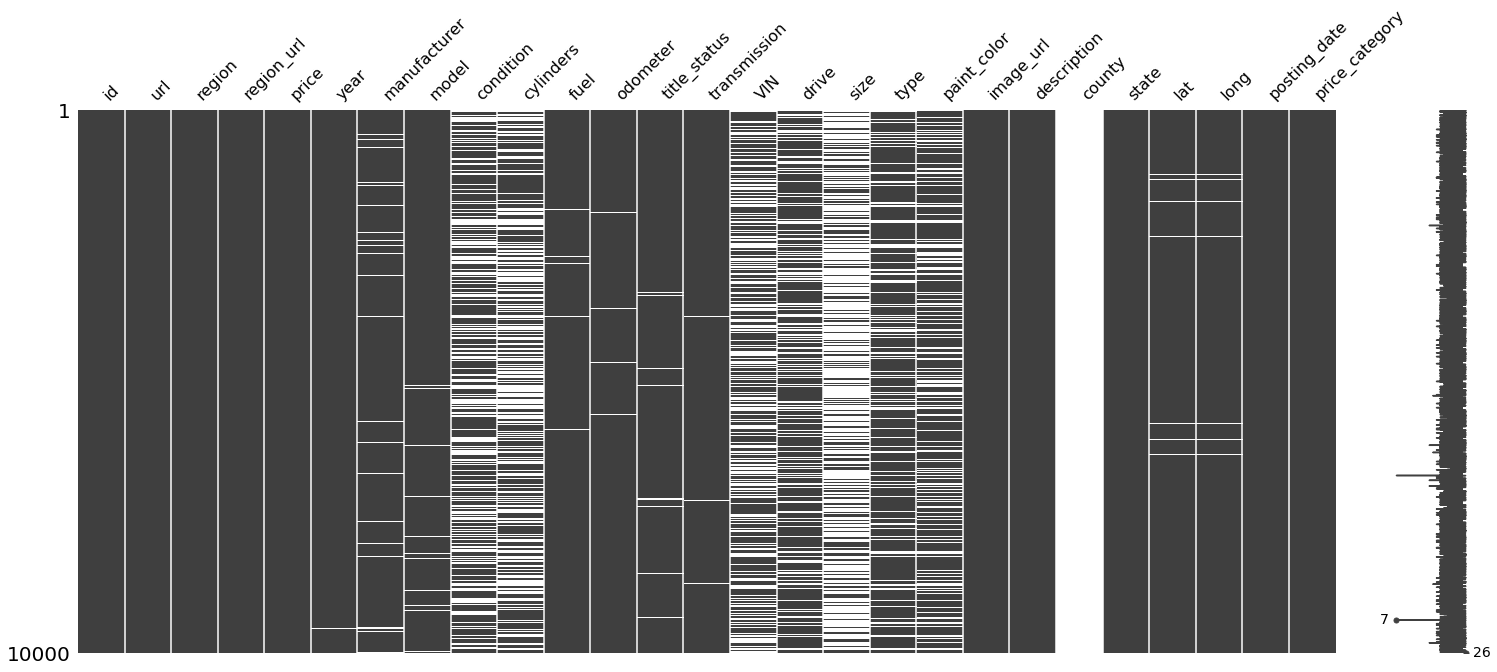

In [16]:
msno.matrix(df)

In [19]:
missing_values(df)

Процент пропущенных значений:


id                  0.00
state               0.00
price               0.00
price_category      0.00
region              0.00
url                 0.00
region_url          0.00
description         0.02
image_url           0.02
posting_date        0.02
year                0.36
odometer            0.43
transmission        0.45
fuel                0.63
lat                 0.98
long                0.98
model               1.28
title_status        1.66
manufacturer        3.82
type               21.94
paint_color        29.50
drive              30.06
condition          37.66
VIN                39.38
cylinders          40.80
size               71.91
county            100.00
dtype: float64

In [21]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 0
Процент полностью заполненных объектов из всей выборки: 0.0


#### Выводы по пропущенным значениям
- Всего 7 столбцов из 27 не имеют пропущенных значений
- в столбце "county" - все значения пропущены

##### 1.2.2.2. Обработка по столбцу   "county"

In [25]:
# Еще раз проверим, что в колонке "county" все значения нулевые
df.county.value_counts(dropna=False)

NaN    10000
Name: county, dtype: int64

In [26]:
# Удаляем столбец с отсутствующими данными
df = df.drop(columns=['county'])

In [27]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 823
Процент полностью заполненных объектов из всей выборки: 8.23


Полностью заполнено чуть больше 8% объектов, а значит удалить такие объекты полностью мы не можем, иначе выборка уменьшится в 12 раз.

##### 1.2.2.3. Обработка столбцов 'VIN', 'condition', 'cylinders', 'size', 'drive', 'paint_color', 'type'
удалим ещё 7 столбцов, в которых более 20% пропущенных значений.

In [28]:
df = df.drop(columns=['VIN', 'condition', 'cylinders', 'size', 'drive', 'paint_color', 'type'])
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9134
Процент полностью заполненных объектов из всей выборки: 91.34


##### 1.2.2.4.  Обработка пропусков в производителях --- "manufacturer" (пропущено - 3.82% данных) -- заполняем "other"

Для 382 объектов производитель не заполнен. Но есть колонки, из которых потенциально можно восстановить производителя — модель автомобиля и его описание. Посмотрим на значение этих двух признаков для тех объектов, в которых не заполнена модель

In [29]:
df[df.manufacturer.isna()][['model', 'description']]

,model,description
21,oldsmobile 442,1970 Oldsmobile 442 Convertible 442 Indy Pace ...
66,Diahatsu,1991 Daihatsu hijet 5 speed extended cab....im...
182,Scion iM Hatchback 4D,Carvana is the safer way to buy a car During t...
201,Voltswagon Beetle,"New Brakes, new serpentine belt, new catalytic..."
217,THOMAS SCHOOL BUS,5.9 CUMMINS DIESEL; 28 Passenger with 2 Rear A...
...,...,...
9908,Scion xD Hatchback 4D,Carvana is the safer way to buy a car During t...
9959,FREIGHTLINER M2 106,"2013 *FREIGHTLINER* *M2 106* M2106 - $24,900Ca..."
9985,Suzuki Grand Vitara,"2012 Suzuki Grand Vitara Premium 4WD - $7,450 ..."
10002,F-150,2020 *Ford* *F-150* 180 MILES. LIFTED FORD F15...


По той малой части, что отобразилась, можно подтвердить, что производитель транспортного средства часто указан в наименовании модели или в описании. Например, в строке с индексом 9985 легко узнается Suzuki. Но чтобы сделать такое заполнение пропущенных значений, нужно будет верно обработать строки, проверить производителей по имеющемуся словарю, поэтому сейчас мы просто заполним пропущенные значения  новым значением “other”

In [30]:
df.manufacturer = df.manufacturer.fillna('other')
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9471
Процент полностью заполненных объектов из всей выборки: 94.71


##### 1.2.2.5. Обработка пропусков в пробеге  --- "odometer"    (пропущено - 0,43% данных) -- заполняем средним

In [31]:
# Выведем количество значений  в колонке с количеством пройденных миль, включая пустые. 
df.odometer.value_counts(dropna=False)

100000.0    50
NaN         43
1.0         42
180000.0    37
200000.0    37
            ..
32086.0      1
126872.0     1
68967.0      1
124248.0     1
61943.0      1
Name: odometer, Length: 7007, dtype: int64

In [32]:
# 43 пустых значения, зададим их через средний параметр - 
print("Среднее значение пробега -- ", int(df.odometer.mean()))
df.odometer = df.odometer.fillna(int(df.odometer.mean()))

Среднее значение пробега --  95674


In [33]:
# Проверим результат
df.odometer.isna().sum()

0

In [34]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9507
Процент полностью заполненных объектов из всей выборки: 95.07


In [ ]:
df.to_csv('data/df_out.csv')

In [ ]:
df= pd.read_csv('df_out.csv')

##### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [35]:
df_info_(df)

Размер выборки - (10000, 19)
Состав выборки - Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer', 'title_status', 'transmission',
       'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
       'price_category'],
      dtype='object')


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442.0,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023.0,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048.0,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high


##### 1.2.2.6. Работаем с пропусками в годе выпуска автомобилей --- year  (пропущено 0,343% данных)¶--  удаляем строки с пустым годом

In [37]:
df = df[df.year.notna()]

##### 1.2.2.7. Отработка пропущенных значений в  поле вида топлива --- fuel (пропущено 0,616% данных)-- заполняем пустые значения "other"

In [38]:
df.fuel = df.fuel.fillna('other')

##### 1.2.2.8. Отработка пропущенных значений в модели автомобиля  --- model (пропущено 1,272% данных)¶-- заполняем пустые значения "other"

In [39]:
df.model = df.model.fillna('other')

##### 1.2.2.9. Отработка пропущенных значений в поле статуса автомобиля  --- title_status (пропущено 1,656% данных) -- заполняем пустые значения значением mode

In [40]:
moda_title = df.title_status.mode()
df.title_status = df.title_status.fillna('moda_title')

##### 1.2.2.10. Отработка пропущенных значений в lat, long (пропущено по 0,98% данных) ---  удаляем строки с пустыми значениями

In [41]:
df = df[~(df.long.isna() | df.lat.isna())]

##### 1.2.2.11 Отработка пропущенных значений в поле коробки передач  --- transmission  (пропущено 0,45% данных) -- заполняем пустые значения "other"

In [42]:
df.transmission = df.transmission.fillna('other')

##### 1.2.2.12 Отработка пропущенных значений в поле даты размещения объявления о продаже --- "posting_date" (пропущено - 0,02% данных) -- удаляем пропущенные строки

In [43]:
# описательные статистики даты размещения объявления о продаже
df.posting_date.describe()

count                         9868
unique                        9828
top       2021-04-11T10:51:21-0400
freq                             2
Name: posting_date, dtype: object

! на месте самой популярной даты может стоять любое из значений, которое встречается два раза

In [44]:
# записи, в которых дата размещения объявления о продаже не заполнена
df[df.posting_date.isna()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category


In [45]:
# особой логики не видно, поэтому удалим записи, где нет данных по дате объявления о продаже
df = df[df.posting_date.notna()]

##### 1.2.2.13.  Проверяем процент заполнения данных в датасете

In [47]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 9868
Процент полностью заполненных объектов из всей выборки: 100.0


### 1.2.3.  Исследование типов данных

#### 1.2.3.1. Изменение типа данных по пробегу --- "odometer", в годе выпуска автомобиля --- "year"

In [48]:
# Меняем тип данных в данных столбцах на более подходящий целочисленный тип
df[['odometer', 'year']] = df[['odometer', 'year']].astype (int)

#### 1.2.3.2. Изменение типа данных по дате размещения объявления о продаже --- "posting_date"

In [49]:
# Дата указана в формате object, создаем новый столбец с верным типом даты ---
df['date'] = pd.to_datetime(df.posting_date, utc=True)

In [50]:
df.to_csv('data/df_clean.csv')

### 2.   Исследование признаков (визуализация, структура, оценка и отработка аномалий и выбросов)

#### 2.1. Исследование данных по пробегу -- "odometer"

##### 2.1.1.  Визуализация данных по пробегу -- "odometer", оценка наличия аномалий и выбросов

In [53]:
df.odometer.describe()

count    9.868000e+03
mean     9.602918e+04
std      8.679010e+04
min      0.000000e+00
25%      3.925250e+04
50%      8.911600e+04
75%      1.371982e+05
max      3.245000e+06
Name: odometer, dtype: float64

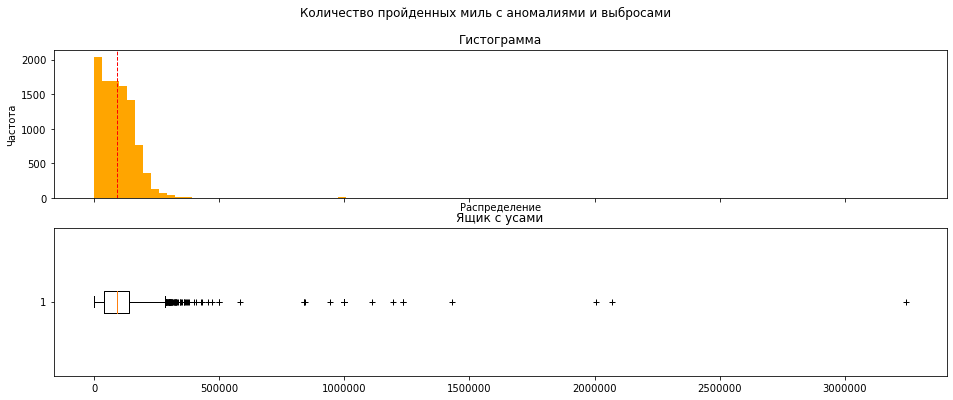

In [57]:
visual_hist_box(df.odometer, 'Количество пройденных миль с аномалиями и выбросами')

! Как видно из описательных характеристик и визуализации - в данных пробега авто явно есть существенные выбросы в данных. С ними необходимо отдельно разбираться

##### 2.1.2. Обработка аномалий и выбросов данных по пробегу -- "odometer" - заменяем на верхнюю границу

In [58]:
# Выводим границы с помощью функции
boundaries = calculate_outliers(df.odometer)
print("Границы для нормальных значений пробега:", boundaries)

Границы для нормальных значений пробега: (-107666.125, 284116.875)


In [59]:
is_outlier = (df.odometer < boundaries[0]) | (df.odometer > boundaries[1])
print("Количество значений меньше нижней и больше верхней границ -- ", is_outlier.sum())
print("Процент значений меньше нижней и больше верхней границ -- ", round((is_outlier.sum() / len(df)*100),2), "%")

Количество значений меньше нижней и больше верхней границ --  90
Процент значений меньше нижней и больше верхней границ --  0.91 %


In [60]:
# Выбросы только среди максимальных значений, поэтому заменим их верхним граничным значением
df.loc[is_outlier, 'odometer'] = int(boundaries[1])

#### 2.2. Исследование данных по году выпуска авто -- "year"

##### 2.2.1.  Визуализация данных по году выпуска авто -- "year", оценка наличия аномалий и выбросов

In [62]:
df.year.describe()

count    9868.000000
mean     2010.909708
std         9.705988
min      1915.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64

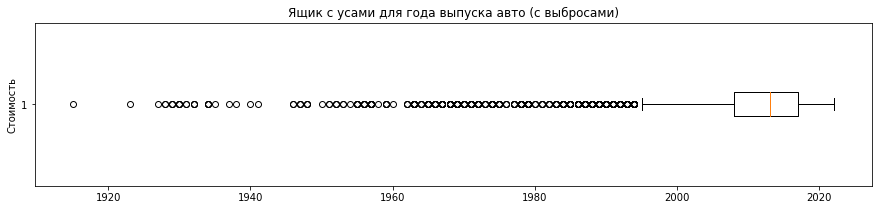

In [63]:
visual_box(df.year, 'Ящик с усами для года выпуска авто (с выбросами)')

##### 2.2.2.  Обработка аномалий и выбросов данных по году выпуска авто -- "year" -- замена выбросов по нижнему значению

In [64]:
borders = calculate_outliers(df.year)
print("Границы для нормальных значений года выпуска:", borders)
is_outlier = (df.year < borders[0]) | (df.year > borders[1]) 
print("Количество значений меньше нижней и больше верхней границ в годе выпуска автомобиля -- ", is_outlier.sum())
print("Процент значений меньше нижней и больше верхней границ (доля выбросов в годе выпуска автомобиля)-- ", round((is_outlier.sum() / len(df)*100),2), "%")

Границы для нормальных значений года выпуска: (1994.5, 2030.5)
Количество значений меньше нижней и больше верхней границ в годе выпуска автомобиля --  394
Процент значений меньше нижней и больше верхней границ (доля выбросов в годе выпуска автомобиля)--  3.99 %


In [65]:
# количество значений для категории цены для записей, в которых год выпуска автомобиля является выбросом
df[is_outlier].price_category.value_counts(dropna=False)

low       181
medium    135
high       78
Name: price_category, dtype: int64

In [66]:
# Так как выбросы в годе выпуска находятся среди минимальных значений, заполним те значения, которые являются выбросами, значением нижней границы
df.loc[is_outlier, 'year'] = int(borders[0])

#### 2.3  Исследование данных по стоимости авто -- "price"

##### 2.3.1. Визуализация данных по стоимости авто -- "price", оценка наличия аномалий и выбросов

In [67]:
#  отображение только  трех знаков после запятой и описательные характеристики
df.price.describe().apply(lambda x: f"{x:0.3f}")

count        9868.000
mean        20602.005
std        125437.186
min           500.000
25%          7800.000
50%         15590.000
75%         27990.000
max      12345678.000
Name: price, dtype: object

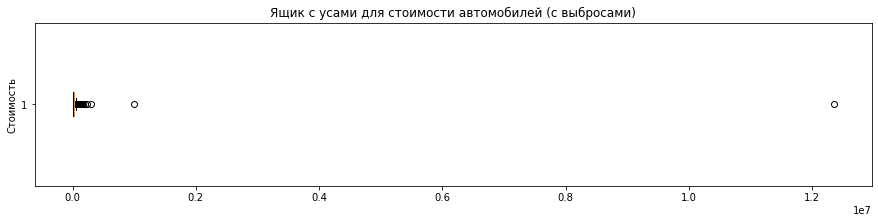

In [68]:
visual_box(df.price, 'Ящик с усами для стоимости автомобилей (c выбросами)')

! Из «ящика с усами» можно увидеть, что выбросы действительно существуют, но из-за их большого разброса основаная часть графика («ящик») почти незаметна

##### 2.3.2.  Обработка аномалий и выбросов данных по стоимости авто -- "price" - удаляем аномалии

In [69]:
# границы для нормальных значений стоимости автомобиля, через интерквартильный размах
boundaries_price = calculate_outliers(df.price)
print("Границы для нормальных значений стоимости авто:", boundaries_price)

Границы для нормальных значений стоимости авто: (-22485.0, 58275.0)


In [70]:
#  количество выбросов в стоимости автомобиля
is_outlier = (df.price < boundaries_price[0]) | (df.price > boundaries_price[1]) 
print("Количество значений меньше нижней и больше верхней границ в стоимости авто -- ", is_outlier.sum())
print("Процент значений меньше нижней и больше верхней границ (доля выбросов в стоимости авто)-- ", round((is_outlier.sum() / len(df)*100),2), "%")

Количество значений меньше нижней и больше верхней границ в стоимости авто --  207
Процент значений меньше нижней и больше верхней границ (доля выбросов в стоимости авто)--  2.1 %


Выбросы только среди максимальных значений, по нижней границе - вопросов нет. 
При этом цены машин с самой высокой стоимостью имеют разные характеристики - по году, по модели. Какой-либо устойчивой зависимости особо не выявляется. Поэтому удалим строки с авто самой высокой стоимости

In [71]:
df = df.drop(df[is_outlier].index)

#### 2.4  Исследуем выбросы в количестве данных по годам - мало данных, убираем 2021,2022 гг

In [88]:
df = df_[(df_.year != 2022)&(df_.year != 2021)]
df.year.describe()

count    9619.000000
mean     2011.515750
std         6.491996
min      1994.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2020.000000
Name: year, dtype: float64

### 3.  Feature Engineering

#### 3.1. Генерация дополнительных фичей

##### 3.1.1.  Доп параметр odometer/price

In [89]:
# Создаем доп поле соотношения пробега на цену
df['odometer/price'] = df.apply(lambda x: x.odometer / x.price, axis=1)

##### 3.1.2.  Доп параметр длины описания desc_len

In [90]:
df['desc_len'] = df.apply(lambda x: len(x.description) , axis=1)

##### 3.1.3.  Доп параметр наличия модели в описании model_in_desc

In [91]:
df['model_in_desc'] = df.apply(lambda x: x.description.count(x.model) , axis=1)

##### 3.1.4.  Доп параметр возрастной категории автомобиля - age_category

In [92]:
df['age_category'] =  df.apply(lambda x: "new" if x.year > 2013 else ("old" if x.year < 2006 else "average"), axis=1)

##### 3.1.5.  Доп параметр длины символов в модели - model_len

In [93]:
df['model_len'] = df.apply(lambda x: len(x.model) , axis=1)

##### 3.1.6.  Доп параметр количества слов в модели - model_word_count

In [94]:
df['model_word_count'] = df.apply(lambda x: len(x.model.split(' ')), axis=1)

##### 3.1.7.  Доп категориальный признак по manufacturer

In [95]:
manufacturer_names = ['audi', 'ford', 'chevrolet', 'toyota', 'jeep', 'honda', 'nissan']
for manufacturer in manufacturer_names:
    col_name = 'is_' + manufacturer
    df[col_name] = df.apply(lambda x: 1 if x.manufacturer == manufacturer else 0, axis=1)

##### 3.1.8.  Доп категориальный признак по fuel

In [96]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(df[['fuel']])

OneHotEncoder(sparse=False)

In [97]:
ohe_fuel = ohe.transform(df[['fuel']])
ohe.get_feature_names()

array(['x0_diesel', 'x0_electric', 'x0_gas', 'x0_hybrid', 'x0_other'],
      dtype=object)

In [98]:
df[ohe.get_feature_names()] = ohe_fuel

##### 3.1.9.  Доп нормализованные признаки по odometer

In [99]:
std_scaler = StandardScaler()
std_scaler.fit(df[['odometer']])
std_scaled = std_scaler.transform(df[['odometer']])
df[['std_scaled_odometer']] = std_scaled
df.shape

(9619, 39)

##### 3.1.10.  Доп признак короткой модели short_model

In [100]:
df['short_model'] = df.apply(lambda x: x.model.split(' ')[0], axis=1)

#### 3.2.  Преобразование, нормализация

##### 3.2.1.  Преобразование категориальных переменных short_model, transmission, region, manufacturer, state, title_status, age_category

In [101]:
data = df[['short_model', 'transmission', 'region', 'manufacturer', 'state', 'title_status', 'age_category']]

In [102]:
ohe_ = OneHotEncoder(sparse=False)
ohe_.fit(data)

OneHotEncoder(sparse=False)

In [103]:
ohe_data_ = ohe_.transform(data)

In [104]:
ohe_.get_feature_names_out(input_features=None)
df[ohe_.get_feature_names_out()] = ohe_data_

##### 3.2.2.  Стандартизация количественных переменных lat, long, year, odometer/price, desc_len, model_in_desc, model_len, model_word_count

In [105]:
df['model_len'] = df.apply(lambda x: len(x.model) , axis=1)
df['model_word_count'] = df.apply(lambda x: len(x.model.split(' ')), axis=1)
categorial_features = ['lat', 'long', 'year', 'odometer/price', 'desc_len', 'model_in_desc', 'model_len', 'model_word_count']
data = df[categorial_features]

In [106]:
std_scaler = StandardScaler()
std_scaler.fit(data)

StandardScaler()

In [107]:
std_scaled = std_scaler.transform(data)
df[['lat_std', 'long_std', 'year_std', 'odometer/price_std', 'desc_len_std', 'model_in_desc_std', 'model_len_std', 'model_word_count_std']] = std_scaled

In [108]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer',
       ...
       'age_category_new', 'age_category_old', 'lat_std', 'long_std',
       'year_std', 'odometer/price_std', 'desc_len_std', 'model_in_desc_std',
       'model_len_std', 'model_word_count_std'],
      dtype='object', length=1488)

##### 3.2.3.  Преобразование даты

In [109]:
df.date = pd.to_datetime(df.date, utc = True)
df['month'] = df.date.dt.month
df['dayofweek'] = df.date.dt.dayofweek

In [110]:
df.posting_date = pd.to_datetime(df.posting_date, utc = True)
df['diff_years'] = df.posting_date.dt.year - df.date.dt.year

In [111]:
std_scaler = StandardScaler()

In [112]:
std_scaler.fit(df[['month','dayofweek', 'diff_years']])
std_scaled = std_scaler.transform(df[['month','dayofweek', 'diff_years']])
df[['month_std', 'dayofweek_std', 'diff_years_std']] = std_scaled

#### 3.3.  Преобразование датафрейма для этапа моделирования

In [113]:
df.shape

(9619, 1494)

In [114]:
columns_for_drop = ['url', 'region', 'region_url', 'month','dayofweek', 'diff_years','year', 'manufacturer', 'model', 'fuel',
                    'odometer', 'title_status','transmission',   'image_url', 'description', 'state', 'lat', 'long',
                    'posting_date', 'date', 'odometer/price', 'desc_len', 'model_in_desc',  'short_model', 'age_category',
                    'model_len', 'model_word_count']
df_prepared = df.drop(df[columns_for_drop], axis =1)

In [115]:
df_prepared.to_csv('data/vehicles_dataset_prepared.csv', index = False)

In [116]:
df = pd.read_csv('data/vehicles_dataset_prepared.csv')

##### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 4. Modelling

##### Описание преобразованного датасета:
- `id`: идентификатор записи;
- `is_manufacturer_name`: признак производителя автомобиля;

- `region_*`: регион;
- `x0_*`: тип топлива;
- `manufacturer_*`: производитель;
- `short_model_*`: сокращённая модель автомобиля;
- `title_status_*`: статус;
- `transmission_*`: коробка передач;
- `state_*`: штат;
- `age_category_*`: возрастная категория автомобиля;

- `std_scaled_odometer`: количество пройденных миль (после стандартизации);
- `year_std`: год выпуска (после стандартизации);
- `lat_std`: широта (после стандартизации);
- `long_std`: долгота (после стандартизации);
- `odometer/price_std`: отношение стоимости к пробегу автомобиля (после стандартизации);
- `desc_len_std`: количество символов в тексте объявления о продаже (после стандартизации);
- `model_in_desc_std`: количество наименований модели автомобиля в тексте объявления о продаже (после стандартизации);
- `model_len_std`: длина наименования автомобиля (после стандартизации);
- `model_word_count_std`: количество слов в наименовании автомобиля (после стандартизации);
- `month_std`: номер месяца размещения объявления о продаже автомобиля (после стандартизации);
- `dayofweek_std`: день недели размещения объявления о продаже автомобиля (после стандартизации);
- `diff_years_std`: количество лет между годом производства автомобиля и годом размещения объявления о продаже автомобиля (после стандартизации);

- `price`: стоимость;
- `price_category`: категория цены.

### 4.1. Инициализация целевой переменной - price_category, разделение на сеты

In [117]:
df_prepared = df.drop(['odometer/price_std', 'price', 'id'], axis=1)

In [118]:
x = df_prepared.drop(['price_category'], axis=1)
y = df_prepared['price_category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [119]:
df_prepared.columns

Index(['price_category', 'is_audi', 'is_ford', 'is_chevrolet', 'is_toyota',
       'is_jeep', 'is_honda', 'is_nissan', 'x0_diesel', 'x0_electric',
       ...
       'lat_std', 'long_std', 'year_std', 'desc_len_std', 'model_in_desc_std',
       'model_len_std', 'model_word_count_std', 'month_std', 'dayofweek_std',
       'diff_years_std'],
      dtype='object', length=1464)

###   4.2. Обучение моделей разными методами

####   4.2.1.  Логистическая регрессия - точность на тестовом сете - 75,7%

In [120]:
logreg = LogisticRegression(random_state=100, max_iter=400, intercept_scaling=100, penalty='l2', solver='sag')

In [121]:
logreg.fit(x_train, y_train)

LogisticRegression(intercept_scaling=100, max_iter=400, random_state=100,
                   solver='sag')

In [122]:
predicted_train_log = logreg.predict(x_train)
predicted_test_log = logreg.predict(x_test)
print(f'TRAIN ACC: {accuracy_score(y_train, predicted_train_log)}')
print(f'TEST ACC: {accuracy_score(y_test, predicted_test_log)}')

TRAIN ACC: 0.8560819842566464
TEST ACC: 0.7571032571032571


In [123]:
confusion_matrix(y_test, predicted_test_log)

array([[805,  25, 167],
       [ 22, 773, 158],
       [158, 171, 607]], dtype=int64)

####   4.2.2. Случайный лес - точность на тестовом сете - 75,3%

In [124]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

RandomForestClassifier()

In [125]:
predicted_train_rf = rf_clf.predict(x_train)
predicted_test_rf = rf_clf.predict(x_test)
print(f'TRAIN ACC RF: {accuracy_score(y_train, predicted_train_rf)}')
print(f'TEST ACC RF: {accuracy_score(y_test, predicted_test_rf)}')

TRAIN ACC RF: 1.0
TEST ACC RF: 0.7557172557172557


In [126]:
confusion_matrix(y_test, predicted_test_rf)

array([[808,  41, 148],
       [ 18, 809, 126],
       [160, 212, 564]], dtype=int64)

####   4.2.3. Многослойный персептрон - точность на тестовом сете - 78,4%

In [127]:
mlp = MLPClassifier(random_state=50, max_iter=500, hidden_layer_sizes=(200,40), activation = 'relu', solver ='sgd',
                    shuffle =False, warm_start=True)
mlp.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(200, 40), max_iter=500, random_state=50,
              shuffle=False, solver='sgd', warm_start=True)

In [128]:
predicted_train_mlp = mlp.predict(x_train)
predicted_test_mlp = mlp.predict(x_test)

print(f'TRAIN ACC MLP: {accuracy_score(y_train, predicted_train_mlp)}')
print(f'TEST ACC MLP: {accuracy_score(y_test, predicted_test_mlp)}')

TRAIN ACC MLP: 0.9772761027773652
TEST ACC MLP: 0.7879417879417879


In [129]:
confusion_matrix(y_test, predicted_test_mlp)

array([[826,  16, 155],
       [ 16, 765, 172],
       [119, 134, 683]], dtype=int64)

###   4.3. Кросс-валидация на тестовой выборке

In [130]:
print(cross_validate(logreg, x_train, y_train, cv=2))
cv_score_log = cross_val_score(logreg, x_train, y_train, cv=5)

{'fit_time': array([17.48199964, 17.73503542]), 'score_time': array([0.02000046, 0.02201104]), 'test_score': array([0.75200475, 0.74806892])}


In [138]:
print(cross_validate(rf_clf, x_train, y_train, cv=2))
cv_score_clf = cross_val_score(rf_clf, x_train, y_train, cv=5)

{'fit_time': array([1.17403269, 1.24300003]), 'score_time': array([0.085006  , 0.10096741]), 'test_score': array([0.74190674, 0.74183007])}


In [132]:
print(cross_validate(mlp, x_train, y_train, cv=2))
cv_score_mlp = cross_val_score(mlp, x_train, y_train, cv=5)

{'fit_time': array([17.59899831, 17.49199963]), 'score_time': array([0.02099991, 0.02100062]), 'test_score': array([0.75200475, 0.74806892])}


###  4.4. Выбор лучшей модели

In [135]:
print("Логистическая регрессия: среднее значение точности модели - ", cv_score_log.mean()*100, "%",  "\nСтандартное отклонение точности модели -", cv_score_log.std())

Логистическая регрессия: среднее значение точности модели -  76.5778886767248 % 
Стандартное отклонение точности модели - 0.020086536027697582


In [136]:
print("Случайный лес: среднее значение точности модели - ", cv_score_clf.mean()*100, "%",  "\nСтандартное отклонение точности модели -", cv_score_clf.std())

Случайный лес: среднее значение точности модели -  75.5679397615746 % 
Стандартное отклонение точности модели - 0.014933880596809881


In [137]:
print("Многослойный персептрон: среднее значение точности модели - ", cv_score_mlp.mean()*100, "%",  "\nСтандартное отклонение точности модели -", cv_score_mlp.std())

Многослойный персептрон: среднее значение точности модели -  79.45929041588208 % 
Стандартное отклонение точности модели - 0.014400896617769365


##### Лучший результат дала модель многослойного персептрона. Выбираем ее.

###   4.5. Кросс-валидация лучшей модели многослойного персептрона на тестовой выборке

In [139]:
cv_score_mlp_test = cross_val_score(mlp, x_test, y_test, cv=5)
print("Многослойный персептрон на тестовой выборке: среднее значение точности модели - ", cv_score_mlp_test.mean()*100, "%",  "\nСтандартное отклонение точности модели -", cv_score_mlp_test.std())

Многослойный персептрон на тестовой выборке: среднее значение точности модели -  74.63547882197022 % 
Стандартное отклонение точности модели - 0.017751720639139316


##### По итогам кросс-валидации на тестовой выборке, точность модели ухудшилась незначительно, модель не переобучена и может быть использована

## 5. RESULTS

##### Выбрана модель многослойного персептрона. Точность модели на всей выборке - 92%

In [140]:
predicted_results_mlp = mlp.predict(x)
print(f'TEST ACC MLP RESULTS: {accuracy_score(y, predicted_results_mlp)}')

TEST ACC MLP RESULTS: 0.920469903316353


In [ ]:
# Сохраняем модель в формате pickle
filename = "model_mlp_pickle.pickle"

with open(filename, 'wb') as file:
    pickle.dump(mlp, file)

In [ ]:
from google.colab import files
files.download("model_mlp_pickle.pickle")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6. Доп исследования

#### 6.1. Визуализации категориальной переменной вид топлива --- "fuel"

In [72]:
stats = df.groupby(['fuel'], as_index=False)[['id']].count()
stats = stats.rename(columns={'id': 'count'})
stats

,fuel,count
0,diesel,561
1,electric,43
2,gas,8215
3,hybrid,104
4,other,738


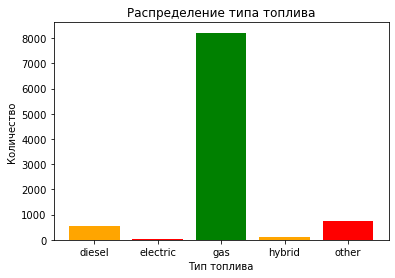

In [73]:
plt.bar(stats['fuel'], stats['count'], color=['orange', 'red', 'green'])
plt.xlabel('Тип топлива')
plt.ylabel('Количество')
plt.title('Распределение типа топлива');

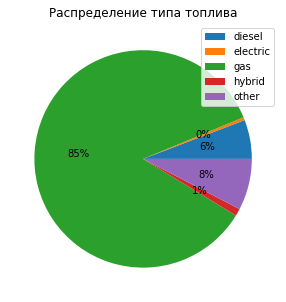

In [74]:
plt.figure(figsize=(6, 5))
plt.pie(stats['count'], labels=stats['fuel'], labeldistance=None, autopct = '%1.0f%%')
plt.title("Распределение типа топлива")
plt.legend()
plt.show();

#### 6.2. Визуализации категориальной переменной производителя --- "manufacturer"

In [75]:
stats_manuf = df.groupby(['manufacturer'], as_index=False)[['id']].count().rename(columns={'id': 'count'}).sort_values('count', ascending=False)

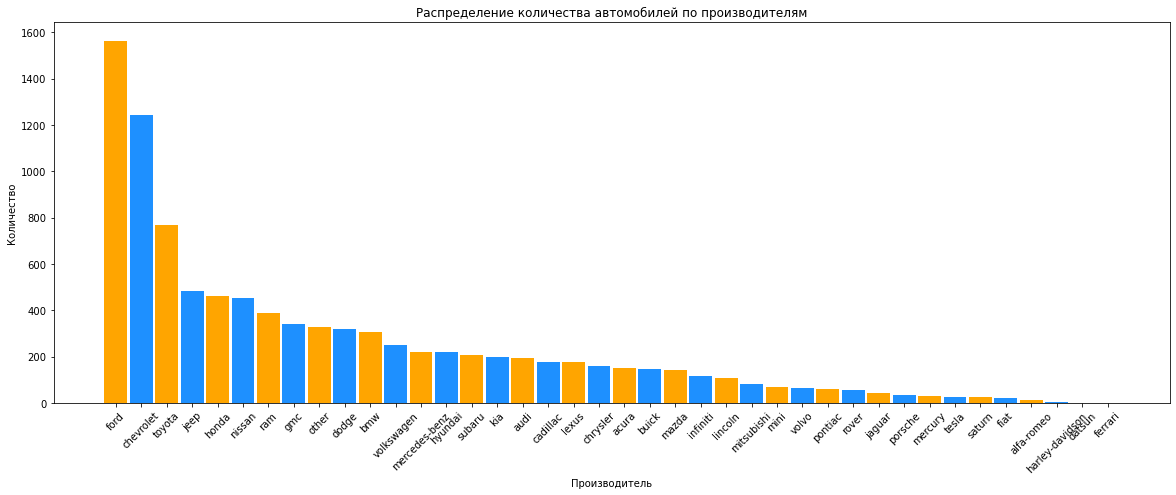

In [76]:
plt.figure(figsize=(20, 7))
plt.bar(stats_manuf['manufacturer'], stats_manuf['count'], width = 0.9, color=['orange', 'dodgerblue'])
plt.xticks(rotation = 45)
plt.xlabel('Производитель')
plt.ylabel('Количество')
plt.title('Распределение количества автомобилей по производителям');

#### 6.3. Визуализации категориальной переменной коробке передач автомобиля --- "transmission"

In [77]:
stats_trans = df.groupby(['transmission'], as_index=False)[['id']].count().rename(columns={'id': 'count'}).sort_values('count', ascending=False)

In [78]:
stats_trans

,transmission,count
0,automatic,7400
2,other,1649
1,manual,612


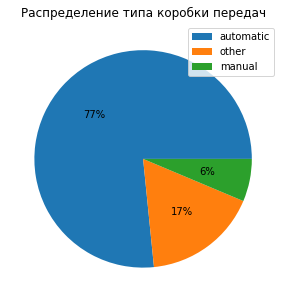

In [79]:
plt.figure(figsize=(8, 5))
plt.pie(stats_trans['count'], labels=stats_trans['transmission'], labeldistance=None, autopct = '%1.0f%%')
plt.title("Распределение типа коробки передач")
plt.legend()
plt.show();

#### 6.4. Исследование зависимости стоимости автомобиля от года выпуска

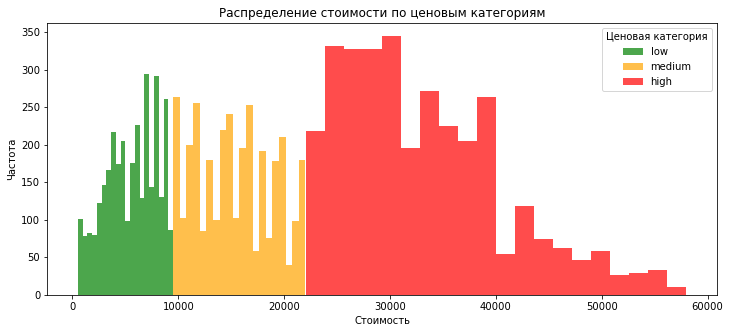

In [80]:
# графики распределения стоимости автомобиля для каждой из ценовой категории автомобил - стоимость соответствует ценовой категории
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}
fig, ax = plt.subplots(figsize=(12, 5))
for price_category in colors:
    color = colors[price_category]
    data = df[df['price_category'] == price_category]

    ax.hist(data['price'], bins=20, color=color, alpha=0.7)

plt.title("Распределение стоимости по ценовым категориям")
plt.xlabel('Стоимость')
plt.ylabel('Частота')
plt.legend(colors, title="Ценовая категория");

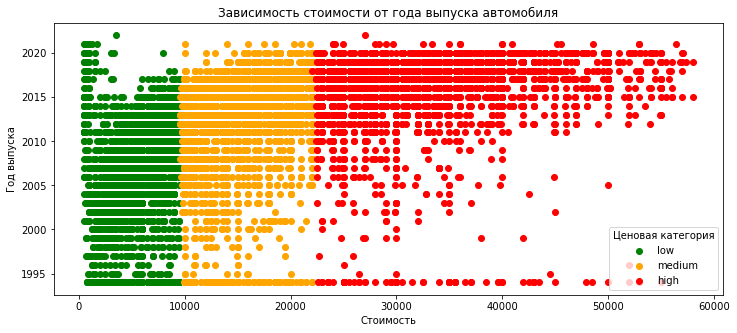

In [81]:
# диаграмма рассеяния для стоимости автомобиля и его года выпуска
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}
fig, ax = plt.subplots(figsize=(12, 5))
for price_category in colors:
    color = colors[price_category]
    data = df[df['price_category'] == price_category]
    ax.scatter(data['price'], data['year'], c=color, label=price_category)
ax.legend(loc='lower right', title="Ценовая категория")
plt.title("Зависимость стоимости от года выпуска автомобиля")
plt.xlabel('Стоимость')
plt.ylabel('Год выпуска')
plt.show()

In [82]:
# Наблюдается зависимость стоимости от года производства, посчитаем количество авто по годам
stats = df.groupby(['year'], as_index=False)[['id']].count()
stats = stats.rename(columns={'id': 'count'})
stats

,year,count
0,1994,386
1,1995,33
2,1996,25
3,1997,44
4,1998,55
5,1999,81
6,2000,78
7,2001,122
8,2002,149
9,2003,185


In [83]:
# Так как в последний год выборки очень мало авто (не полный период), то исключим его из исследования
df_ = df[(df.year != 2022)&(df.year != 2021)]
stats = df_.groupby(['year']).agg({'price': 'mean'})
stats = stats.rename(columns={'price': 'price_mean'})
stats

,price_mean
year,
1994,13528.049223
1995,9610.060606
1996,9362.960000
1997,6441.250000
1998,6528.672727
1999,7446.641975
2000,7614.410256
2001,7852.090164
2002,7173.798658


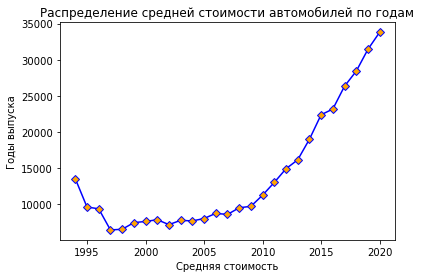

In [84]:
plt.plot(stats, color='blue', marker = 'D', markerfacecolor = 'orange')
plt.xlabel('Средняя стоимость')
plt.ylabel('Годы выпуска')
plt.title('Распределение средней стоимости автомобилей по годам');

In [85]:
# Оценим корреляцию цены от года производства
df_['year'].corr(df_['price'])

0.5449141798232536

Таким образом, можно сделать вывод о существовании прямой линейной связи между стоимостью авто и годом его производства, но корреляция среднего уровня, т.к. коэффициент Пирсона менее 0,7. т.е. с ростом года, растет стоимость

#### 6.5. Исследование зависимости стоимости автомобиля от пробега

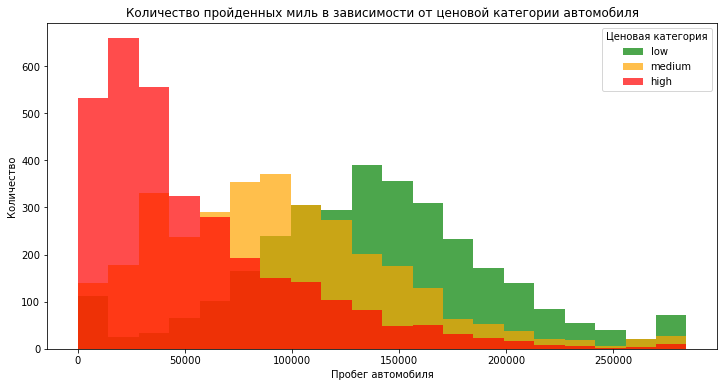

In [86]:
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}
fig, ax = plt.subplots(figsize=(12, 6))
for price_category in colors:
    color = colors[price_category]
    data = df[df['price_category'] == price_category]
    ax.hist(data['odometer'], bins=20, color=color, alpha=0.7)   
plt.ylabel('Количество')
plt.xlabel('Пробег автомобиля')
plt.title('Количество пройденных миль в зависимости от ценовой категории автомобиля')
plt.legend(colors, title="Ценовая категория");

Выводы
- в целом видна обратная зависимость цены авто от пробега 
- но есть пересечение практически во всех категориях и уровнях пробега
- наибольшее количество авто в высокой ценовой категории и с небольшим пробегом

#### 6.6. Исследование зависимости пробега от года выпуска

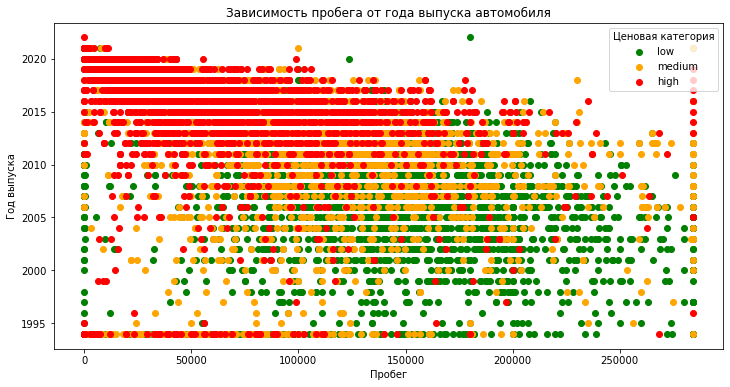

In [87]:
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}
fig, ax = plt.subplots(figsize=(12, 6))
for price_category in colors:
    color = colors[price_category]
    data = df[df['price_category'] == price_category]
    ax.scatter(data['odometer'], data['year'], c=color, label=price_category)
ax.legend(loc='upper right', title="Ценовая категория")
plt.title("Зависимость пробега от года выпуска автомобиля")
plt.xlabel('Пробег')
plt.ylabel('Год выпуска')
plt.show()

- Диаграмма показывает общую структуру данных в разрезе года выпуска, пробега и цены авто.
- Видно в каком квадранте находится наибольшее количество авто, а также общий масштаб рассеяния
- наглядно, что есть авто с крайне небольшим пробегом, но низкой и  средней стоимостью и обратно
- есть целый блок авто с максимальным пробегом, но высокой и средней ценой авто